In [1]:
!pip install -q flwr[simulation] torch torchvision

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 111.7 GB  | Proc size: 507.1 MB
GPU RAM Free: 15736MB | Used: 434MB | Util   3% | Total 16376MB


In [3]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [5]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [18]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times = {}
        self.client_metrics = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [19]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [32]:
strategy = FedCustom()
fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-18 11:31:43,562	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 59784405812.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 29892202905.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54472) Epoch 9: train loss 0.037431, accuracy 0.572000 [repeated 4x across cluster]
(ClientAppActor pid=54472) [Client 5] evaluate, config: {}
(ClientAppActor pid=54472) Training time for Client 4: 24.87 seconds
(ClientAppActor pid=49472) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=54472) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.908472061157227and 0habhhahah
this is tehb mode time [22.91]
This is ths last time not a fantasy 23.738790273666382and 9habhhahah
this is tehb mode time [22.91, 23.74]
This is ths last time not a fantasy 23.013939380645752and 3habhhahah
this is tehb mode time [22.91, 23.74, 23.01]
This is ths last time not a fantasy 22.598590850830078and 1habhhahah
this is tehb mode time [22.91, 23.74, 23.01, 22.6]
This is ths last time not a fantasy 23.41482901573181and 5habhhahah
this is tehb mode time [22.91, 23.74, 23.01, 22.6, 23.41]
This is ths last time not a fantasy 24.871550798416138and 4habhhahah
this is tehb mode time [22.91, 23.74, 23.01, 22.6, 23.41, 24.87]
This is ths last time not a fantasy 22.842337131500244and 8habhhahah
this is tehb mode time [22.91, 23.74, 23.01, 22.6, 23.41, 24.87, 22.84]
This is ths last time not a fantasy 22.897274017333984and 2habhhahah
this is tehb mode time [22.91, 23.74, 23.01, 22.6, 23.41, 24.87, 22.84, 22.9]
This is ths

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45712) [Client 9] evaluate, config: {}
(ClientAppActor pid=45712) Epoch 8: train loss 0.026198, accuracy 0.707778 [repeated 2x across cluster]
(ClientAppActor pid=45712) Training time for Client 6: 21.58 seconds
(ClientAppActor pid=50212) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49348) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.54772186279297and 3habhhahah
this is tehb mode time [20.55]
This is ths last time not a fantasy 20.844207286834717and 9habhhahah
this is tehb mode time [20.55, 20.84]
This is ths last time not a fantasy 21.329973220825195and 7habhhahah
this is tehb mode time [20.55, 20.84, 21.33]
This is ths last time not a fantasy 22.058854818344116and 1habhhahah
this is tehb mode time [20.55, 20.84, 21.33, 22.06]
This is ths last time not a fantasy 20.1819589138031and 8habhhahah
this is tehb mode time [20.55, 20.84, 21.33, 22.06, 20.18]
This is ths last time not a fantasy 20.09704566001892and 5habhhahah
this is tehb mode time [20.55, 20.84, 21.33, 22.06, 20.18, 20.1]
This is ths last time not a fantasy 20.245280504226685and 4habhhahah
this is tehb mode time [20.55, 20.84, 21.33, 22.06, 20.18, 20.1, 20.25]
This is ths last time not a fantasy 20.396547317504883and 2habhhahah
this is tehb mode time [20.55, 20.84, 21.33, 22.06, 20.18, 20.1, 20.25, 20.4]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54472) [Client 9] evaluate, config: {}
(ClientAppActor pid=54472) Epoch 8: train loss 0.013504, accuracy 0.856667 [repeated 2x across cluster]
(ClientAppActor pid=54472) Training time for Client 6: 21.94 seconds
(ClientAppActor pid=49472) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.336353540420532and 1habhhahah
this is tehb mode time [20.34]
This is ths last time not a fantasy 20.073717832565308and 8habhhahah
this is tehb mode time [20.34, 20.07]
This is ths last time not a fantasy 20.08129572868347and 4habhhahah
this is tehb mode time [20.34, 20.07, 20.08]
This is ths last time not a fantasy 21.93660283088684and 6habhhahah
this is tehb mode time [20.34, 20.07, 20.08, 21.94]
This is ths last time not a fantasy 20.842517852783203and 9habhhahah
this is tehb mode time [20.34, 20.07, 20.08, 21.94, 20.84]
This is ths last time not a fantasy 21.37171244621277and 0habhhahah
this is tehb mode time [20.34, 20.07, 20.08, 21.94, 20.84, 21.37]
This is ths last time not a fantasy 20.141660928726196and 2habhhahah
this is tehb mode time [20.34, 20.07, 20.08, 21.94, 20.84, 21.37, 20.14]
This is ths last time not a fantasy 20.336233854293823and 7habhhahah
this is tehb mode time [20.34, 20.07, 20.08, 21.94, 20.84, 21.37, 20.14, 20.34]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49472) Epoch 8: train loss 0.006081, accuracy 0.942222 [repeated 4x across cluster]
(ClientAppActor pid=49472) [Client 9] evaluate, config: {}
(ClientAppActor pid=49472) Training time for Client 3: 21.65 seconds
(ClientAppActor pid=35180) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.625132083892822and 2habhhahah
this is tehb mode time [22.63]
This is ths last time not a fantasy 21.648648738861084and 3habhhahah
this is tehb mode time [22.63, 21.65]
This is ths last time not a fantasy 19.576449394226074and 0habhhahah
this is tehb mode time [22.63, 21.65, 19.58]
This is ths last time not a fantasy 20.40773844718933and 9habhhahah
this is tehb mode time [22.63, 21.65, 19.58, 20.41]
This is ths last time not a fantasy 22.478439569473267and 7habhhahah
this is tehb mode time [22.63, 21.65, 19.58, 20.41, 22.48]
This is ths last time not a fantasy 22.57034921646118and 4habhhahah
this is tehb mode time [22.63, 21.65, 19.58, 20.41, 22.48, 22.57]
This is ths last time not a fantasy 20.286261558532715and 6habhhahah
this is tehb mode time [22.63, 21.65, 19.58, 20.41, 22.48, 22.57, 20.29]
This is ths last time not a fantasy 22.66046142578125and 1habhhahah
this is tehb mode time [22.63, 21.65, 19.58, 20.41, 22.48, 22.57, 20.29, 22.66]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=24468) [Client 1] evaluate, config: {}
(ClientAppActor pid=24468) Epoch 8: train loss 0.002681, accuracy 0.979333 [repeated 3x across cluster]
(ClientAppActor pid=24468) Training time for Client 8: 21.75 seconds
(ClientAppActor pid=45712) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=24468) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.586971282958984and 0habhhahah
this is tehb mode time [22.59]
This is ths last time not a fantasy 19.887990474700928and 9habhhahah
this is tehb mode time [22.59, 19.89]
This is ths last time not a fantasy 20.70266628265381and 4habhhahah
this is tehb mode time [22.59, 19.89, 20.7]
This is ths last time not a fantasy 20.598580837249756and 3habhhahah
this is tehb mode time [22.59, 19.89, 20.7, 20.6]
This is ths last time not a fantasy 19.79120111465454and 1habhhahah
this is tehb mode time [22.59, 19.89, 20.7, 20.6, 19.79]
This is ths last time not a fantasy 20.12631845474243and 7habhhahah
this is tehb mode time [22.59, 19.89, 20.7, 20.6, 19.79, 20.13]
This is ths last time not a fantasy 20.078333377838135and 6habhhahah
this is tehb mode time [22.59, 19.89, 20.7, 20.6, 19.79, 20.13, 20.08]
This is ths last time not a fantasy 21.668336629867554and 5habhhahah
this is tehb mode time [22.59, 19.89, 20.7, 20.6, 19.79, 20.13, 20.08, 21.67]
This is ths last t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35180) [Client 2] evaluate, config: {}
(ClientAppActor pid=35180) Epoch 8: train loss 0.003412, accuracy 0.968667 [repeated 2x across cluster]
(ClientAppActor pid=35180) Training time for Client 8: 21.73 seconds
(ClientAppActor pid=54472) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=50212) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.90041422843933and 0habhhahah
this is tehb mode time [20.9]
This is ths last time not a fantasy 20.324575424194336and 4habhhahah
this is tehb mode time [20.9, 20.32]
This is ths last time not a fantasy 20.378066539764404and 1habhhahah
this is tehb mode time [20.9, 20.32, 20.38]
This is ths last time not a fantasy 21.734965801239014and 8habhhahah
this is tehb mode time [20.9, 20.32, 20.38, 21.73]
This is ths last time not a fantasy 20.25079870223999and 6habhhahah
this is tehb mode time [20.9, 20.32, 20.38, 21.73, 20.25]
This is ths last time not a fantasy 20.388060569763184and 5habhhahah
this is tehb mode time [20.9, 20.32, 20.38, 21.73, 20.25, 20.39]
This is ths last time not a fantasy 20.05261206626892and 3habhhahah
this is tehb mode time [20.9, 20.32, 20.38, 21.73, 20.25, 20.39, 20.05]
This is ths last time not a fantasy 20.084315538406372and 7habhhahah
this is tehb mode time [20.9, 20.32, 20.38, 21.73, 20.25, 20.39, 20.05, 20.08]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=54472) [Client 8] evaluate, config: {}
(ClientAppActor pid=54472) Epoch 8: train loss 0.003854, accuracy 0.960000 [repeated 2x across cluster]
(ClientAppActor pid=54472) Training time for Client 9: 21.27 seconds
(ClientAppActor pid=54472) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=49348) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.37067937850952and 7habhhahah
this is tehb mode time [20.37]
This is ths last time not a fantasy 20.054523468017578and 6habhhahah
this is tehb mode time [20.37, 20.05]
This is ths last time not a fantasy 19.946731567382812and 3habhhahah
this is tehb mode time [20.37, 20.05, 19.95]
This is ths last time not a fantasy 21.26674461364746and 9habhhahah
this is tehb mode time [20.37, 20.05, 19.95, 21.27]
This is ths last time not a fantasy 20.6297869682312and 0habhhahah
this is tehb mode time [20.37, 20.05, 19.95, 21.27, 20.63]
This is ths last time not a fantasy 20.30989694595337and 4habhhahah
this is tehb mode time [20.37, 20.05, 19.95, 21.27, 20.63, 20.31]
This is ths last time not a fantasy 19.837024688720703and 1habhhahah
this is tehb mode time [20.37, 20.05, 19.95, 21.27, 20.63, 20.31, 19.84]
This is ths last time not a fantasy 21.429396867752075and 2habhhahah
this is tehb mode time [20.37, 20.05, 19.95, 21.27, 20.63, 20.31, 19.84, 21.43]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49472) [Client 1] evaluate, config: {}
(ClientAppActor pid=49472) Epoch 8: train loss 0.003982, accuracy 0.956222 [repeated 3x across cluster]
(ClientAppActor pid=49472) Training time for Client 5: 21.81 seconds
(ClientAppActor pid=45556) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=45712) [Client 6] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.031135320663452and 4habhhahah
this is tehb mode time [20.03]
This is ths last time not a fantasy 20.511447191238403and 3habhhahah
this is tehb mode time [20.03, 20.51]
This is ths last time not a fantasy 20.274183988571167and 0habhhahah
this is tehb mode time [20.03, 20.51, 20.27]
This is ths last time not a fantasy 19.9144766330719and 9habhhahah
this is tehb mode time [20.03, 20.51, 20.27, 19.91]
This is ths last time not a fantasy 21.80554723739624and 5habhhahah
this is tehb mode time [20.03, 20.51, 20.27, 19.91, 21.81]
This is ths last time not a fantasy 21.00593400001526and 6habhhahah
this is tehb mode time [20.03, 20.51, 20.27, 19.91, 21.81, 21.01]
This is ths last time not a fantasy 21.348195552825928and 8habhhahah
this is tehb mode time [20.03, 20.51, 20.27, 19.91, 21.81, 21.01, 21.35]
This is ths last time not a fantasy 20.538231372833252and 2habhhahah
this is tehb mode time [20.03, 20.51, 20.27, 19.91, 21.81, 21.01, 21.35, 20.54]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=49472) [Client 0] evaluate, config: {}
(ClientAppActor pid=49472) Epoch 8: train loss 0.008557, accuracy 0.905556 [repeated 4x across cluster]
(ClientAppActor pid=49472) Training time for Client 1: 21.92 seconds
(ClientAppActor pid=45556) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.09965753555298and 0habhhahah
this is tehb mode time [20.1]
This is ths last time not a fantasy 20.104067087173462and 5habhhahah
this is tehb mode time [20.1, 20.1]
This is ths last time not a fantasy 20.2564914226532and 9habhhahah
this is tehb mode time [20.1, 20.1, 20.26]
This is ths last time not a fantasy 20.63504958152771and 4habhhahah
this is tehb mode time [20.1, 20.1, 20.26, 20.64]
This is ths last time not a fantasy 21.91991925239563and 1habhhahah
this is tehb mode time [20.1, 20.1, 20.26, 20.64, 21.92]
This is ths last time not a fantasy 20.4509174823761and 8habhhahah
this is tehb mode time [20.1, 20.1, 20.26, 20.64, 21.92, 20.45]
This is ths last time not a fantasy 20.53361415863037and 2habhhahah
this is tehb mode time [20.1, 20.1, 20.26, 20.64, 21.92, 20.45, 20.53]
This is ths last time not a fantasy 20.67730402946472and 3habhhahah
this is tehb mode time [20.1, 20.1, 20.26, 20.64, 21.92, 20.45, 20.53, 20.68]
This is ths last time not a 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=45712) [Client 6] evaluate, config: {}
(ClientAppActor pid=45712) Epoch 8: train loss 0.005927, accuracy 0.935111 [repeated 4x across cluster]
(ClientAppActor pid=45712) Training time for Client 6: 21.89 seconds
(ClientAppActor pid=35180) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 608.36s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.057514160513877866
INFO :      		round 2: 0.04358501536846161
INFO :      		round 3: 0.04766103067398071
INFO :      		round 4: 0.05701343027353286
INFO :      		round 5: 0.06272199375629425
INFO :      		round 6: 0.06713182603120804
INFO :      		round 7: 0.07160336406230926
INFO :      		round 8: 0.07342810468673706
INFO :      		round 9: 0.07378424623012543
INFO :      		round 10: 0.07722301442623139
INFO :      


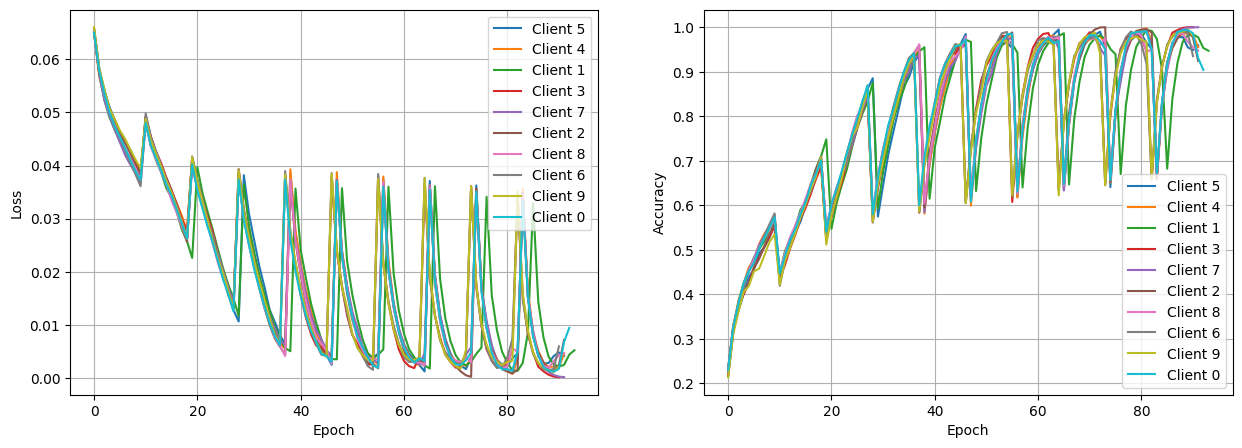

In [33]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")
    

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()
    

    plt.show()

plot_metrics(strategy.client_metrics)

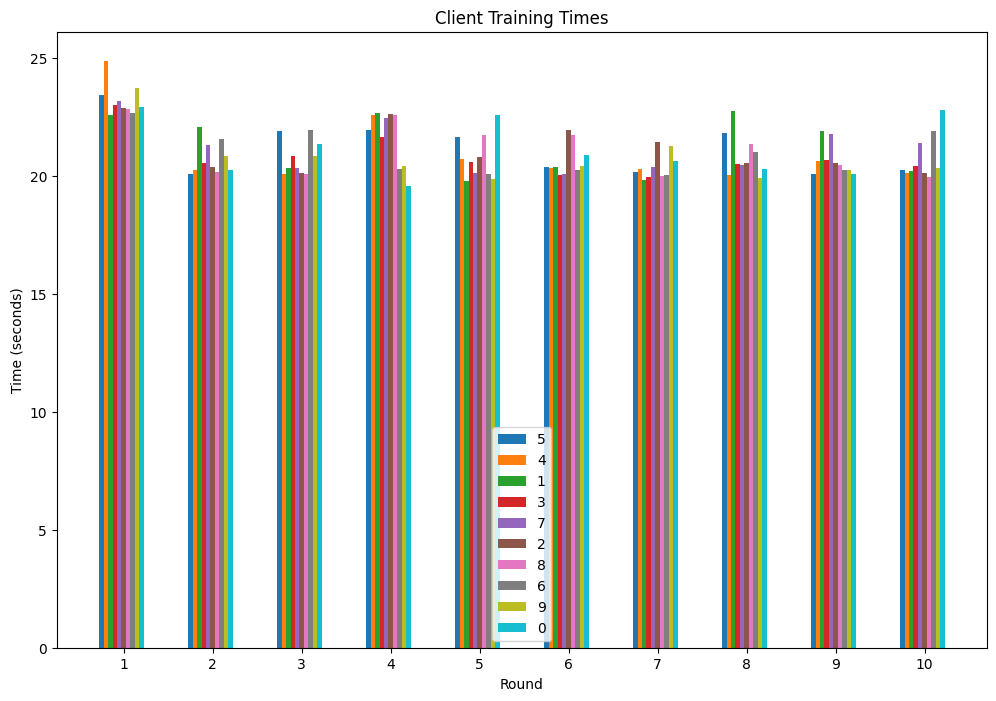

In [42]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()
    
    
    plt.show()

plot_times(strategy.client_training_times)

In [35]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 5 metrics: 92
Client 4 metrics: 92
Client 1 metrics: 94
Client 3 metrics: 91
Client 7 metrics: 92
Client 2 metrics: 92
Client 8 metrics: 92
Client 6 metrics: 91
Client 9 metrics: 91
Client 0 metrics: 93


In [36]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [37]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times = {}
        self.client_metrics = {}

    def parse_metrics(self, cid, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store = self.client_metrics.setdefault(cid, [])
        last_epoch = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2]))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated

# fl.simulation.start_simulation(
#     client_fn=client_fn,
#     num_clients=10,
#     config=fl.server.ServerConfig(num_rounds=10),
#     client_resources=client_resources,
# )

In [44]:
strategy_fed_avg = FedAvgCustom()

fl.common.logger.configure(identifier="myflExp", filename="FLLOG.txt")

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-18 17:32:00,707	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 32858995507.0, 'accelerator_type:RTX': 1.0, 'node:127.0.0.1': 1.0, 'GPU': 1.0, 'memory': 66670989517.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17208) [Client 2] get_parameters
(ClientAppActor pid=17208) [Client 6] fit, config: {}
(ClientAppActor pid=17208) Epoch 0: train loss 0.065252, accuracy 0.209778
(ClientAppActor pid=17208) Epoch 1: train loss 0.057516, accuracy 0.326889
(ClientAppActor pid=26124) [Client 9] fit, config: {}
(ClientAppActor pid=17208) Epoch 2: train loss 0.052884, accuracy 0.381333
(ClientAppActor pid=26124) Epoch 0: train loss 0.064120, accuracy 0.238444
(ClientAppActor pid=32820) [Client 4] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=27824) Epoch 2: train loss 0.052614, accuracy 0.387556 [repeated 12x across cluster]
(ClientAppActor pid=48028) [Client 1] fit, config: {}
(ClientAppActor pid=32820) Epoch 2: train loss 0.052019, accuracy 0.397333 [repeated 18x across cluster]
(ClientAppActor pid=17208) [Client 2] fit, config: {}
(ClientAppActor pid=21816) Epoch 5: train loss 0.044559, accuracy 0.488222 [repeated 19x across cluster]
(ClientAppActor pid=26124) Epoch 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26124) Epoch 9: train loss 0.037378, accuracy 0.564222 [repeated 2x across cluster]
(ClientAppActor pid=26124) [Client 2] evaluate, config: {}
(ClientAppActor pid=26124) Client 2 loss 0.05605627822875976
(ClientAppActor pid=26124) Client 2 accuracy 0.37
(ClientAppActor pid=21816) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=21816) Client 9 loss 0.05658993911743164 [repeated 4x across cluster]
(ClientAppActor pid=21816) Client 9 accuracy 0.374 [repeated 4x across cluster]
(ClientAppActor pid=32820) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48028) [Client 7] fit, config: {}
(ClientAppActor pid=48028) Client 5 loss 0.05422393846511841 [repeated 5x across cluster]
(ClientAppActor pid=48028) Client 5 accuracy 0.406 [repeated 5x across cluster]
(ClientAppActor pid=48028) [Client 5] evaluate, config: {}
(ClientAppActor pid=48028) Epoch 0: train loss 0.046223, accuracy 0.468222
(ClientAppActor pid=26124) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=21816) Epoch 0: train loss 0.046501, accuracy 0.470444 [repeated 11x across cluster]
(ClientAppActor pid=27824) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48028) Epoch 5: train loss 0.033593, accuracy 0.616000 [repeated 18x across cluster]
(ClientAppActor pid=32820) Epoch 7: train loss 0.028121, accuracy 0.679333 [repeated 19x across cluster]
(ClientAppActor pid=32820) Epoch 9: train loss 0.023105, accuracy 0.737556 [repeated 16x across cluster]
(ClientAppActor pid=48028) [Client 5] fit, config: {}
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32820) [Client 4] evaluate, config: {}
(ClientAppActor pid=32820) Client 4 loss 0.04316393315792084
(ClientAppActor pid=32820) Client 4 accuracy 0.52
(ClientAppActor pid=32820) Epoch 9: train loss 0.023800, accuracy 0.736889
(ClientAppActor pid=21816) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7088) Client 7 loss 0.04129289305210113 [repeated 3x across cluster]
(ClientAppActor pid=7088) Client 7 accuracy 0.576 [repeated 3x across cluster]
(ClientAppActor pid=32820) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32820) Client 6 loss 0.04110271394252777 [repeated 5x across cluster]
(ClientAppActor pid=32820) Client 6 accuracy 0.58 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48028) [Client 3] fit, config: {}
(ClientAppActor pid=48028) [Client 1] evaluate, config: {}
(ClientAppActor pid=48028) Client 1 loss 0.040810434103012085
(ClientAppActor pid=48028) Client 1 accuracy 0.578
(ClientAppActor pid=48028) Epoch 0: train loss 0.039891, accuracy 0.538222
(ClientAppActor pid=7088) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=57020) Epoch 0: train loss 0.040279, accuracy 0.538889 [repeated 11x across cluster]
(ClientAppActor pid=27824) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Epoch 3: train loss 0.027543, accuracy 0.683556 [repeated 18x across cluster]
(ClientAppActor pid=57020) Epoch 5: train loss 0.022642, accuracy 0.746889 [repeated 19x across cluster]
(ClientAppActor pid=48028) [Client 5] fit, config: {}
(ClientAppActor pid=32820) Epoch 9: train loss 0.011284, accuracy 0.882000 [repeated 18x across cluster]
(ClientAppActor pid=32820) [Client 4] fit, config: {}
(Clien

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32820) [Client 3] evaluate, config: {}
(ClientAppActor pid=32820) Client 3 loss 0.050989613294601444
(ClientAppActor pid=32820) Client 3 accuracy 0.546
(ClientAppActor pid=32820) Epoch 9: train loss 0.011479, accuracy 0.875556
(ClientAppActor pid=32820) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32820) Client 2 loss 0.05100332248210907 [repeated 4x across cluster]
(ClientAppActor pid=32820) Client 2 accuracy 0.522 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=27824) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=27824) [Client 0] fit, config: {}
(ClientAppActor pid=27824) Client 4 loss 0.04936831760406494 [repeated 5x across cluster]
(ClientAppActor pid=27824) Client 4 accuracy 0.534 [repeated 5x across cluster]
(ClientAppActor pid=27824) Epoch 0: train loss 0.037580, accuracy 0.577778
(ClientAppActor pid=17208) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48028) Epoch 0: train loss 0.037639, accuracy 0.586000 [repeated 11x across cluster]
(ClientAppActor pid=57020) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27824) Epoch 5: train loss 0.014006, accuracy 0.845111 [repeated 17x across cluster]
(ClientAppActor pid=7088) Epoch 6: train loss 0.010884, accuracy 0.882000 [repeated 20x across cluster]
(ClientAppActor pid=27824) [Client 9] fit, config: {}
(ClientAppActor pid=26124) Epoch 9: train loss 0.005785, accuracy 0.943111 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26124) Epoch 9: train loss 0.005344, accuracy 0.952000 [repeated 5x across cluster]
(ClientAppActor pid=26124) [Client 0] evaluate, config: {}
(ClientAppActor pid=26124) Client 0 loss 0.0569800968170166
(ClientAppActor pid=26124) Client 0 accuracy 0.564
(ClientAppActor pid=48028) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=48028) Client 1 loss 0.05514230370521545 [repeated 4x across cluster]
(ClientAppActor pid=48028) Client 1 accuracy 0.578 [repeated 4x across cluster]
(ClientAppActor pid=7088) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7088) Client 6 loss 0.05643586874008179 [repeated 4x across cluster]
(ClientAppActor pid=7088) Client 6 accuracy 0.578 [repeated 4x across cluster]
(ClientAppActor pid=48028) [Client 7] fit, config: {}
(ClientAppActor pid=48028) [Client 8] evaluate, config: {}
(ClientAppActor pid=48028) Epoch 0: train loss 0.037920, accuracy 0.598222
(ClientAppActor pid=48028) Client 8 loss 0.06199409639835358
(ClientAppActor pid=48028) Client 8 accuracy 0.584
(ClientAppActor pid=57020) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=57020) Epoch 0: train loss 0.038560, accuracy 0.592444 [repeated 8x across cluster]
(ClientAppActor pid=26124) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=57020) Epoch 3: train loss 0.016291, accuracy 0.820000 [repeated 21x across cluster]
(ClientAppActor pid=27824) Epoch 4: train loss 0.011756, accuracy 0.872444 [repeated 18x across cluster]
(ClientAppActor pid=48028) [Client 5] fit, config: {

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32820) Epoch 9: train loss 0.003706, accuracy 0.964000 [repeated 5x across cluster]
(ClientAppActor pid=32820) [Client 5] evaluate, config: {}
(ClientAppActor pid=32820) Client 5 loss 0.05887127327919006
(ClientAppActor pid=32820) Client 5 accuracy 0.572
(ClientAppActor pid=17208) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 0 loss 0.06561313080787659 [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 0 accuracy 0.554 [repeated 4x across cluster]
(ClientAppActor pid=32820) [Client 9] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48028) Client 7 loss 0.0611184241771698 [repeated 5x across cluster]
(ClientAppActor pid=48028) Client 7 accuracy 0.568 [repeated 5x across cluster]
(ClientAppActor pid=48028) [Client 0] fit, config: {}
(ClientAppActor pid=48028) [Client 7] evaluate, config: {}
(ClientAppActor pid=48028) Epoch 0: train loss 0.038604, accuracy 0.608222
(ClientAppActor pid=32820) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Epoch 2: train loss 0.016718, accuracy 0.812222 [repeated 11x across cluster]
(ClientAppActor pid=26124) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=32820) Epoch 3: train loss 0.012376, accuracy 0.865556 [repeated 18x across cluster]
(ClientAppActor pid=21816) Epoch 5: train loss 0.006614, accuracy 0.936889 [repeated 19x across cluster]
(ClientAppActor pid=21816) Epoch 7: train loss 0.002972, accuracy 0.978444 [repeated 16x across cluster]
(ClientAppActor pid=48028) [Client 9] fit, config: {}
(Cl

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17208) [Client 5] evaluate, config: {}
(ClientAppActor pid=17208) Client 5 loss 0.06329491686820984
(ClientAppActor pid=17208) Client 5 accuracy 0.58
(ClientAppActor pid=17208) Epoch 9: train loss 0.003634, accuracy 0.963778 [repeated 2x across cluster]
(ClientAppActor pid=32820) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=21816) Client 1 loss 0.06412377643585206 [repeated 4x across cluster]
(ClientAppActor pid=21816) Client 1 accuracy 0.578 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=32820) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32820) Client 9 loss 0.06958163261413575 [repeated 5x across cluster]
(ClientAppActor pid=32820) Client 9 accuracy 0.57 [repeated 5x across cluster]
(ClientAppActor pid=32820) [Client 2] fit, config: {}
(ClientAppActor pid=32820) Epoch 0: train loss 0.038650, accuracy 0.610667
(ClientAppActor pid=57020) [Client 6] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=32820) Epoch 3: train loss 0.009947, accuracy 0.894889 [repeated 12x across cluster]
(ClientAppActor pid=27824) [Client 9] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=17208) Epoch 4: train loss 0.005992, accuracy 0.944889 [repeated 20x across cluster]
(ClientAppActor pid=32820) Epoch 8: train loss 0.002192, accuracy 0.982889 [repeated 20x across cluster]
(ClientAppActor pid=32820) [Client 5] fit, config: {}
(ClientAppActor pid=17208) Epoch 9: train loss 0.003432, accuracy 0.968222 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=48028) [Client 5] evaluate, config: {}
(ClientAppActor pid=48028) Epoch 9: train loss 0.003887, accuracy 0.958889 [repeated 4x across cluster]
(ClientAppActor pid=48028) Client 5 loss 0.06500749158859252
(ClientAppActor pid=48028) Client 5 accuracy 0.568
(ClientAppActor pid=26124) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7088) Client 3 loss 0.07227105998992919 [repeated 3x across cluster]
(ClientAppActor pid=7088) Client 3 accuracy 0.568 [repeated 3x across cluster]
(ClientAppActor pid=48028) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=21816) Client 8 loss 0.0716319580078125 [repeated 4x across cluster]
(ClientAppActor pid=21816) Client 8 accuracy 0.584 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7088) [Client 0] fit, config: {}
(ClientAppActor pid=7088) [Client 7] evaluate, config: {}
(ClientAppActor pid=7088) Client 7 loss 0.0676505720615387 [repeated 2x across cluster]
(ClientAppActor pid=7088) Client 7 accuracy 0.572 [repeated 2x across cluster]
(ClientAppActor pid=7088) Epoch 0: train loss 0.036313, accuracy 0.639556
(ClientAppActor pid=32820) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=21816) Epoch 0: train loss 0.038437, accuracy 0.616444 [repeated 11x across cluster]
(ClientAppActor pid=57020) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=48028) Epoch 4: train loss 0.004968, accuracy 0.956889 [repeated 17x across cluster]
(ClientAppActor pid=21816) Epoch 5: train loss 0.003214, accuracy 0.976667 [repeated 20x across cluster]
(ClientAppActor pid=57020) Epoch 6: train loss 0.002346, accuracy 0.982222 [repeated 19x across cluster]
(ClientAppActor pid=7088) [Client 1] fit, config: {}
(ClientAp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26124) [Client 3] evaluate, config: {}
(ClientAppActor pid=26124) Client 3 loss 0.0732755479812622
(ClientAppActor pid=26124) Client 3 accuracy 0.578
(ClientAppActor pid=26124) Epoch 9: train loss 0.003797, accuracy 0.961333
(ClientAppActor pid=21816) [Client 5] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=57020) Client 0 loss 0.07267773985862731 [repeated 4x across cluster]
(ClientAppActor pid=57020) Client 0 accuracy 0.548 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=17208) [Client 6] fit, config: {}
(ClientAppActor pid=17208) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 1 loss 0.06649511790275574 [repeated 5x across cluster]
(ClientAppActor pid=17208) Client 1 accuracy 0.592 [repeated 5x across cluster]
(ClientAppActor pid=17208) Epoch 0: train loss 0.034404, accuracy 0.661778
(ClientAppActor pid=32820) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=7088) Epoch 2: train loss 0.010256, accuracy 0.891778 [repeated 11x across cluster]
(ClientAppActor pid=48028) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Epoch 5: train loss 0.002348, accuracy 0.982889 [repeated 18x across cluster]
(ClientAppActor pid=7088) Epoch 7: train loss 0.000845, accuracy 0.996889 [repeated 20x across cluster]
(ClientAppActor pid=17208) [Client 7] fit, config: {}
(ClientAppActor pid=26124) Epoch 7: train loss 0.003953, accuracy 0.957111 [repe

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7088) [Client 3] evaluate, config: {}
(ClientAppActor pid=7088) Client 3 loss 0.07533478355407715
(ClientAppActor pid=7088) Client 3 accuracy 0.572
(ClientAppActor pid=7088) Epoch 9: train loss 0.003117, accuracy 0.968222
(ClientAppActor pid=26124) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=17208) Client 0 loss 0.07633823418617249 [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 0 accuracy 0.544 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=7088) [Client 1] fit, config: {}
(ClientAppActor pid=7088) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=7088) Client 4 loss 0.07430783748626708 [repeated 5x across cluster]
(ClientAppActor pid=7088) Client 4 accuracy 0.536 [repeated 5x across cluster]
(ClientAppActor pid=7088) Epoch 0: train loss 0.034523, accuracy 0.661333
(ClientAppActor pid=26124) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Epoch 0: train loss 0.037284, accuracy 0.648667 [repeated 11x across cluster]
(ClientAppActor pid=48028) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=27824) Epoch 4: train loss 0.002370, accuracy 0.985111 [repeated 17x across cluster]
(ClientAppActor pid=32820) Epoch 6: train loss 0.000493, accuracy 0.999111 [repeated 20x across cluster]
(ClientAppActor pid=7088) [Client 7] fit, config: {}
(ClientAppActor pid=21816) Epoch 9: train loss 0.008624, accuracy 0.909333 [repeated

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=21816) Epoch 9: train loss 0.007095, accuracy 0.924444 [repeated 5x across cluster]
(ClientAppActor pid=21816) [Client 8] evaluate, config: {}
(ClientAppActor pid=21816) Client 8 loss 0.07586378359794617
(ClientAppActor pid=21816) Client 8 accuracy 0.608
(ClientAppActor pid=17208) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 9 loss 0.07646102285385131 [repeated 4x across cluster]
(ClientAppActor pid=17208) Client 9 accuracy 0.552 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 638.62s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.055287113046646116
INFO :      		round 2: 0.04240125323534012
INFO :      		round 3: 0.04837400969266891
INFO :      		round 4: 0.05770772413015366
INFO :      		round 5: 0.06432567632198334
INFO :      		round 6: 0.06827543036937714
INFO :      		round 7: 0.06997274131774903
INFO :      		round 8: 0.07126357381343842
INFO :      		round 9: 0.07526024943590164
INFO :      		round 10: 0.07523838052749635
INFO :      


(ClientAppActor pid=7088) [Client 2] evaluate, config: {} [repeated 5x across cluster]


History (loss, distributed):
	round 1: 0.055287113046646116
	round 2: 0.04240125323534012
	round 3: 0.04837400969266891
	round 4: 0.05770772413015366
	round 5: 0.06432567632198334
	round 6: 0.06827543036937714
	round 7: 0.06997274131774903
	round 8: 0.07126357381343842
	round 9: 0.07526024943590164
	round 10: 0.07523838052749635

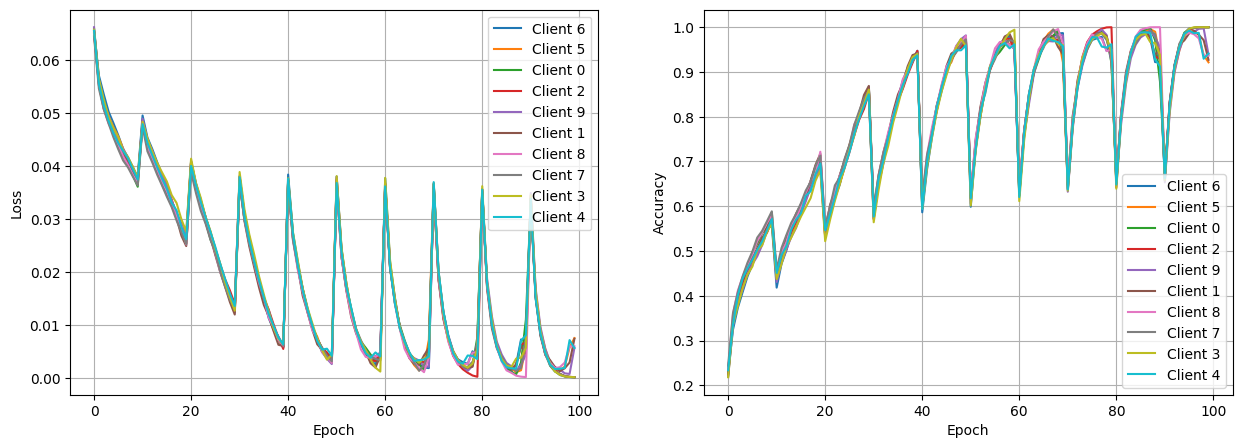

In [43]:
plot_metrics(strategy_fed_avg.client_metrics)

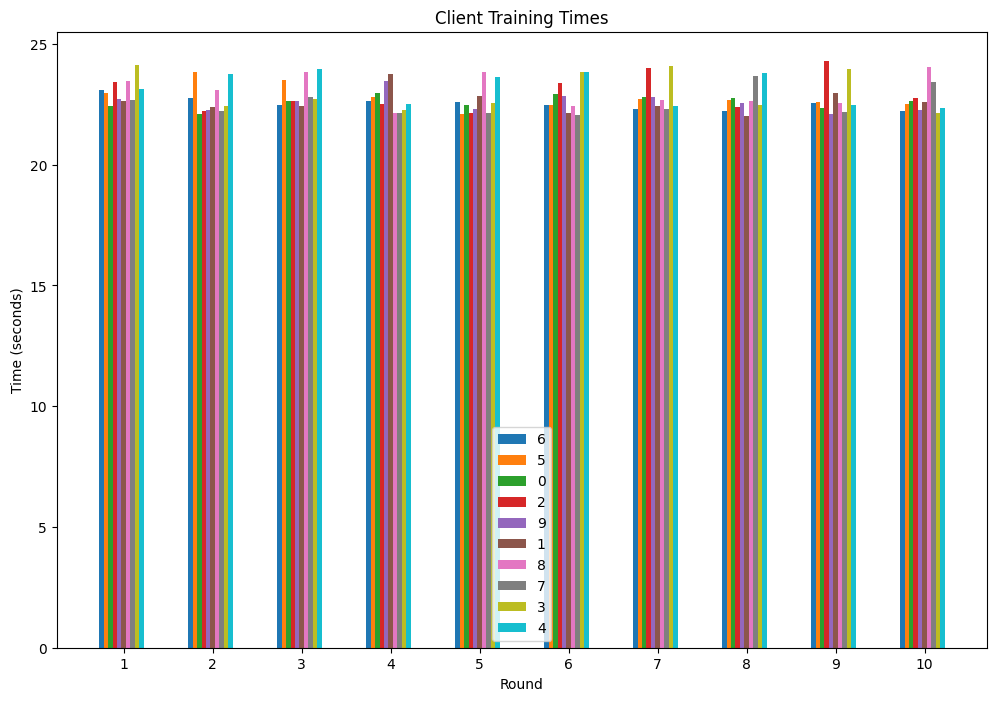

In [40]:
plot_times(strategy_fed_avg.client_training_times)